<a href="https://colab.research.google.com/github/Action52/HumanDataProject/blob/main/Pipeline_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Decoding Brain Waves: Training architectures

## Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install ncps -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00


We need to log in wandb to be able to track the results of our experiments.

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Unzip the files, use -q for quiet mode.

In [ ]:
# Change to the path where you have the EEG (Project A4) datasets.
!unzip -q "/content/drive/MyDrive/Kuliah/BDMA/HDA/Project/datasets.zip" -d "/content"

In [ ]:
cd '/content'

/content


In [ ]:
rm -R HumanDataProject

rm: cannot remove 'HumanDataProject': No such file or directory


Install the latest version of our code. It includes the model definitions under the models/ folder.

In [ ]:
!git clone 'https://github.com/Action52/HumanDataProject/'

Cloning into 'HumanDataProject'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 332 (delta 22), reused 26 (delta 11), pack-reused 292
Receiving objects: 100% (332/332), 14.11 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (231/231), done.


In [ ]:
cd HumanDataProject

/content/HumanDataProject


In [ ]:
mkdir results

In [ ]:
mkdir saved_model

## Training different architectures

In [ ]:
from hda.preprocessor import *
from hda.models.model import *
from hda.models.base_model import *
from hda.constants import *
from hda.utils import *

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import time

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load Config

In [ ]:
config = load_config("colab_config.yaml")
batch_size, versions, time_steps, diodes = get_dataset_shape(config)

### Preprocess and split into train, val, test sets

In [ ]:
preprocessor = Preprocessor("colab_config.yaml")
train_dataset, val_dataset, test_dataset = preprocessor.run()

get approximate dataset size: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Approximate dataset size: 27641


In [ ]:
with tf.device('/device:GPU:0'):
  y_train = np.concatenate([np.array([label.numpy()]) for _, label in train_dataset.unbatch()], axis=0)
  classes = np.unique(y_train)

load segments: 100%|██████████| 2257/2257 [00:00<00:00, 9881.12it/s]


### Define the models

In [ ]:
print(config['epochs'])
fit_args = {
        "x": train_dataset,
        "epochs": config['epochs'],
        "validation_data": val_dataset,
    }

if config['with_weights']:
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    fit_args['class_weight'] = class_weight_dict

30


#### Run all the models

Model: "time_series_model_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windows_convolution_layer   multiple                  7812      
 (WindowsConvolutionLayer)                                       
                                                                 
 dense_layer (DenseLayer)    multiple                  3032294   
                                                                 
Total params: 3040106 (11.60 MB)
Trainable params: 3040106 (11.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


wandb: Currently logged in as: satriabw (bdma). Use `wandb login --relogin` to force relogin


Epoch 1/30
30/30 [==============================] - 46s 463ms/step - loss: 1.8956 - accuracy: 0.2174 - val_loss: 1.7103 - val_accuracy: 0.2818
Epoch 2/30
30/30 [==============================] - 8s 181ms/step - loss: 1.6693 - accuracy: 0.2763 - val_loss: 1.6217 - val_accuracy: 0.2964
Epoch 3/30
30/30 [==============================] - 7s 183ms/step - loss: 1.5929 - accuracy: 0.3180 - val_loss: 1.5315 - val_accuracy: 0.3533
Epoch 4/30
30/30 [==============================] - 7s 184ms/step - loss: 1.4661 - accuracy: 0.4073 - val_loss: 1.3421 - val_accuracy: 0.4818
Epoch 5/30
30/30 [==============================] - 7s 183ms/step - loss: 1.2679 - accuracy: 0.5085 - val_loss: 1.1717 - val_accuracy: 0.5500
Epoch 6/30
30/30 [==============================] - 7s 190ms/step - loss: 1.1711 - accuracy: 0.5527 - val_loss: 1.1376 - val_accuracy: 0.5668
Epoch 7/30
30/30 [==============================] - 7s 186ms/step - loss: 1.0977 - accuracy: 0.5862 - val_loss: 1.0800 - val_accuracy: 0.5842
Epoch

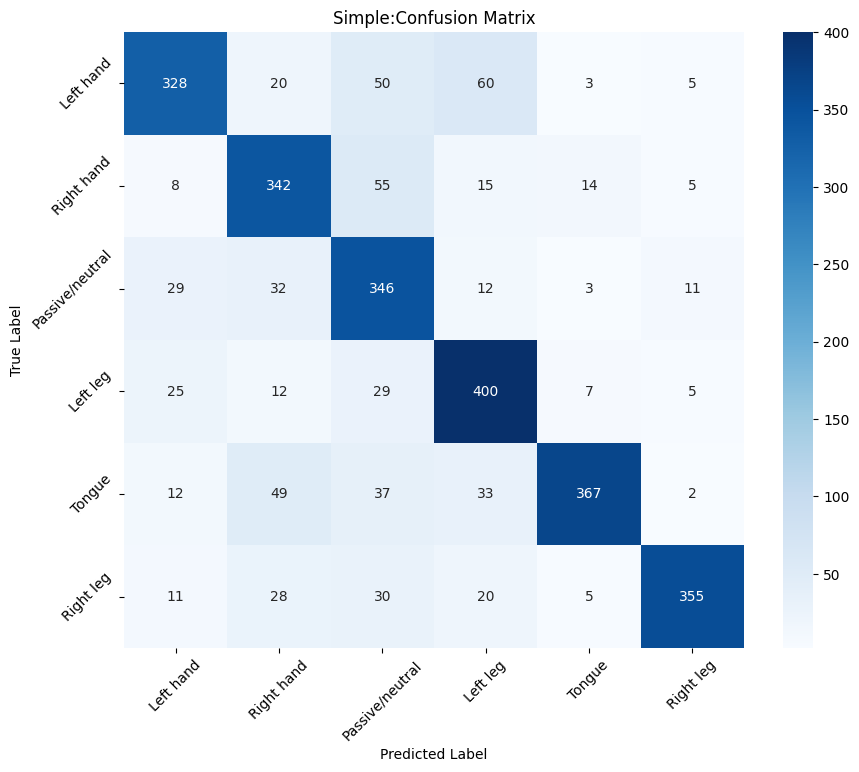

Average Prediction Time (s/sample),▁
Model Weights (MB),▁
Number of Parameters,▁
Test Accuracy,▁
Test F1-score,▁
Test Precision,▁
Test Recall,▁
accuracy,▁▂▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▄▅▅▅▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇██████


In [ ]:
with tf.device('/device:GPU:0'):
      name = "Simple"
      model = TimeSeriesModelSimple(diodes, config['convolutions_conf'], config['dense_conf'])

      fit_args["experiment_name"] = f"{name}"

      # Instantiate the model
      model.build(input_shape=(batch_size, versions, time_steps, diodes))

      # Wrap the model with WandbKerasModel
      wandb_model = WandbKerasModel(
          model=model, project_name="hda-big-3", config={}, entity="bdma"
      )
      # Model summary to check the architecture
      wandb_model.model.summary()

      # Compile and fit the model
      start_time = time.time()
      wandb_model.compile_and_fit(
          compile_args={
              "optimizer": "adam",
              "loss": "sparse_categorical_crossentropy",
              "metrics": ["accuracy"],
          },
          fit_args=fit_args,
          config_path='colab_config.yaml'
      )
      end_time = time.time() - start_time
      print(f"Training time of {config['epochs']} epochs, running for: {end_time} seconds")

      # Evaluate the model on the test set and print the confusion matrix
      predict_and_plot(wandb_model, test_dataset, config, title=f"{name}")

      wandb_model.finish_experiment()

      del wandb_model
      del model

Model: "time_series_model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windows_convolution_layer   multiple                  7812      
 (WindowsConvolutionLayer)                                       
                                                                 
 lstm (LSTM)                 multiple                  324096    
                                                                 
 dense_layer (DenseLayer)    multiple                  770278    
                                                                 
Total params: 1102186 (4.20 MB)
Trainable params: 1102186 (4.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


wandb: Currently logged in as: satriabw (bdma). Use `wandb login --relogin` to force relogin


Epoch 1/30
30/30 [==============================] - 48s 473ms/step - loss: 1.5675 - accuracy: 0.3554 - val_loss: 1.4458 - val_accuracy: 0.4307
Epoch 2/30
30/30 [==============================] - 8s 194ms/step - loss: 1.3112 - accuracy: 0.4989 - val_loss: 1.2691 - val_accuracy: 0.5120
Epoch 3/30
30/30 [==============================] - 6s 160ms/step - loss: 1.1805 - accuracy: 0.5491 - val_loss: 1.0906 - val_accuracy: 0.5864
Epoch 4/30
30/30 [==============================] - 7s 195ms/step - loss: 1.0826 - accuracy: 0.5920 - val_loss: 1.0452 - val_accuracy: 0.6107
Epoch 5/30
30/30 [==============================] - 7s 197ms/step - loss: 1.0391 - accuracy: 0.6078 - val_loss: 0.9676 - val_accuracy: 0.6392
Epoch 6/30
30/30 [==============================] - 7s 196ms/step - loss: 0.9934 - accuracy: 0.6232 - val_loss: 0.9538 - val_accuracy: 0.6429
Epoch 7/30
30/30 [==============================] - 7s 201ms/step - loss: 0.9533 - accuracy: 0.6464 - val_loss: 0.8829 - val_accuracy: 0.6698
Epoch

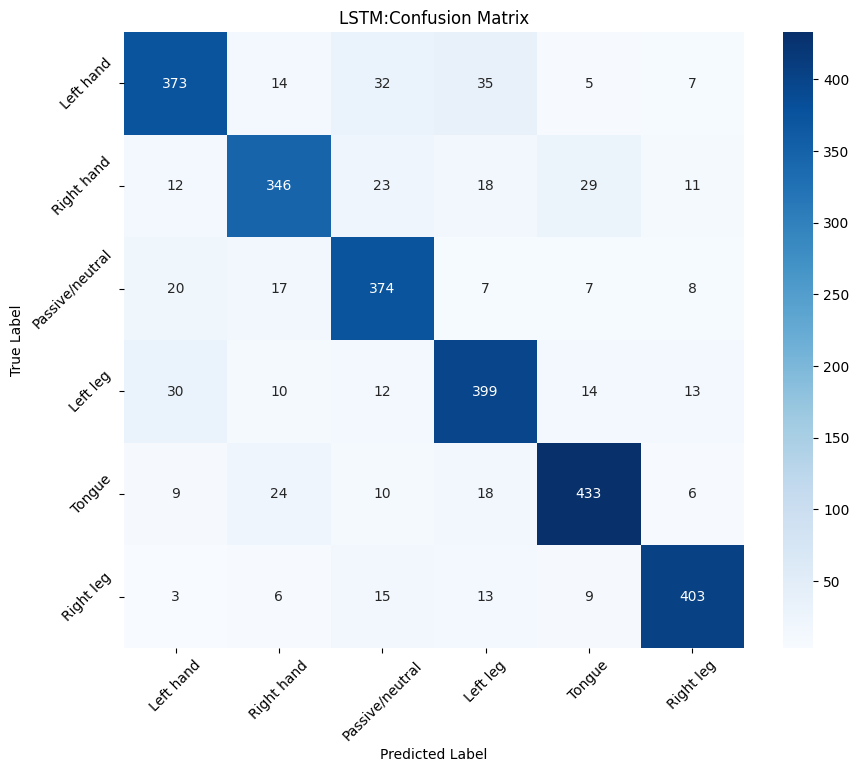

Average Prediction Time (s/sample),▁
Model Weights (MB),▁
Number of Parameters,▁
Test Accuracy,▁
Test F1-score,▁
Test Precision,▁
Test Recall,▁
accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇████


In [ ]:
with tf.device('/device:GPU:0'):
      name = "LSTM"
      model = TimeSeriesModelLSTM(diodes, config['convolutions_conf'], config['dense_conf'], lstm_conf=config['lstm'])

      fit_args["experiment_name"] = f"{name}"

      # Instantiate the model
      model.build(input_shape=(batch_size, versions, time_steps, diodes))

      # Wrap the model with WandbKerasModel
      wandb_model = WandbKerasModel(
          model=model, project_name="hda-big-3", config={}, entity="bdma"
      )
      # Model summary to check the architecture
      wandb_model.model.summary()

      # Compile and fit the model
      start_time = time.time()
      wandb_model.compile_and_fit(
          compile_args={
              "optimizer": "adam",
              "loss": "sparse_categorical_crossentropy",
              "metrics": ["accuracy"],
          },
          fit_args=fit_args,
          config_path='colab_config.yaml'
      )
      end_time = time.time() - start_time
      print(f"Training time of {config['epochs']} epochs, running for: {end_time} seconds")

      # Evaluate the model on the test set and print the confusion matrix
      predict_and_plot(wandb_model, test_dataset, config, title=f"{name}")

      wandb_model.finish_experiment()

      del wandb_model
      del model

Model: "time_series_model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windows_convolution_layer   multiple                  7812      
 (WindowsConvolutionLayer)                                       
                                                                 
 gru (GRU)                   multiple                  243456    
                                                                 
 dense_layer (DenseLayer)    multiple                  770278    
                                                                 
Total params: 1021546 (3.90 MB)
Trainable params: 1021546 (3.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


wandb: Currently logged in as: satriabw (bdma). Use `wandb login --relogin` to force relogin


Epoch 1/30
30/30 [==============================] - 48s 469ms/step - loss: 1.5826 - accuracy: 0.3585 - val_loss: 1.3736 - val_accuracy: 0.4620
Epoch 2/30
30/30 [==============================] - 8s 195ms/step - loss: 1.2828 - accuracy: 0.5113 - val_loss: 1.2297 - val_accuracy: 0.5297
Epoch 3/30
30/30 [==============================] - 7s 198ms/step - loss: 1.1607 - accuracy: 0.5571 - val_loss: 1.0758 - val_accuracy: 0.5896
Epoch 4/30
30/30 [==============================] - 7s 196ms/step - loss: 1.0666 - accuracy: 0.5961 - val_loss: 1.0100 - val_accuracy: 0.6215
Epoch 5/30
30/30 [==============================] - 7s 194ms/step - loss: 1.0032 - accuracy: 0.6213 - val_loss: 1.0226 - val_accuracy: 0.6105
Epoch 6/30
30/30 [==============================] - 7s 194ms/step - loss: 1.0079 - accuracy: 0.6200 - val_loss: 0.9191 - val_accuracy: 0.6570
Epoch 7/30
30/30 [==============================] - 7s 196ms/step - loss: 0.9506 - accuracy: 0.6419 - val_loss: 0.8890 - val_accuracy: 0.6741
Epoch

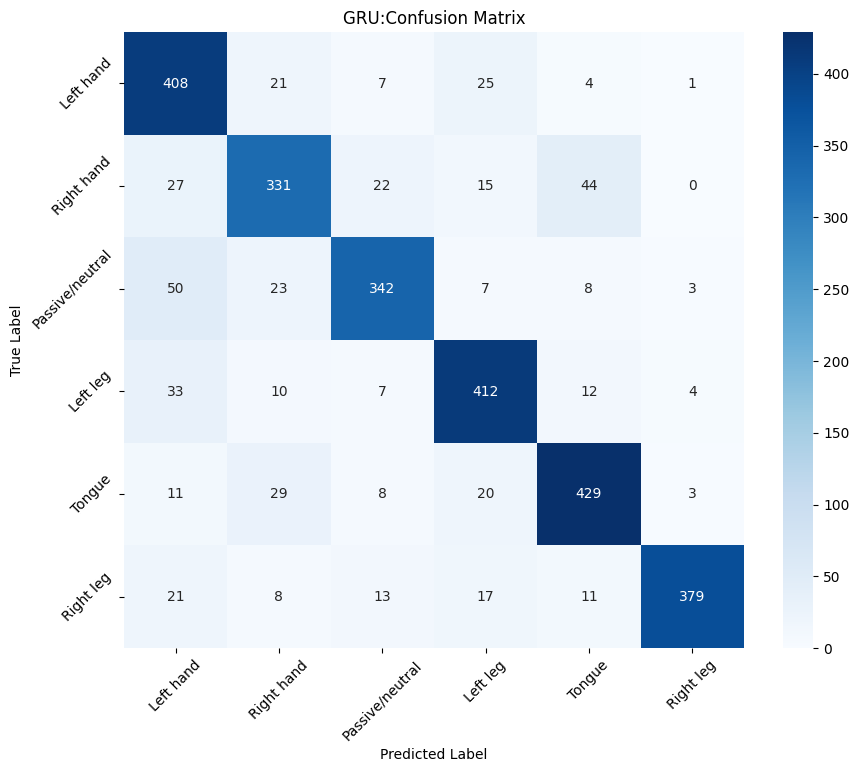

Average Prediction Time (s/sample),▁
Model Weights (MB),▁
Number of Parameters,▁
Test Accuracy,▁
Test F1-score,▁
Test Precision,▁
Test Recall,▁
accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇██▇


In [ ]:
with tf.device('/device:GPU:0'):
      name = "GRU"
      model = TimeSeriesModelGRU(diodes, config['convolutions_conf'], config['dense_conf'], gru_conf=config['gru'])

      fit_args["experiment_name"] = f"{name}"

      # Instantiate the model
      model.build(input_shape=(batch_size, versions, time_steps, diodes))

      # Wrap the model with WandbKerasModel
      wandb_model = WandbKerasModel(
          model=model, project_name="hda-big-3", config={}, entity="bdma"
      )
      # Model summary to check the architecture
      wandb_model.model.summary()

      # Compile and fit the model
      start_time = time.time()
      wandb_model.compile_and_fit(
          compile_args={
              "optimizer": "adam",
              "loss": "sparse_categorical_crossentropy",
              "metrics": ["accuracy"],
          },
          fit_args=fit_args,
          config_path='colab_config.yaml'
      )
      end_time = time.time() - start_time
      print(f"Training time of {config['epochs']} epochs, running for: {end_time} seconds")

      # Evaluate the model on the test set and print the confusion matrix
      predict_and_plot(wandb_model, test_dataset, config, title=f"{name}")

      wandb_model.finish_experiment()

      del wandb_model
      del model

Model: "time_series_model_cf_c"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windows_convolution_layer   multiple                  7812      
 (WindowsConvolutionLayer)                                       
                                                                 
 cf_c (CfC)                  multiple                  147072    
                                                                 
 dense_layer (DenseLayer)    multiple                  770278    
                                                                 
Total params: 925162 (3.53 MB)
Trainable params: 925162 (3.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


wandb: Currently logged in as: satriabw (bdma). Use `wandb login --relogin` to force relogin


Epoch 1/30
30/30 [==============================] - 54s 638ms/step - loss: 1.5291 - accuracy: 0.3875 - val_loss: 1.3155 - val_accuracy: 0.4849
Epoch 2/30
30/30 [==============================] - 15s 406ms/step - loss: 1.2670 - accuracy: 0.5108 - val_loss: 1.1757 - val_accuracy: 0.5484
Epoch 3/30
30/30 [==============================] - 14s 410ms/step - loss: 1.1545 - accuracy: 0.5582 - val_loss: 1.0507 - val_accuracy: 0.6036
Epoch 4/30
30/30 [==============================] - 14s 413ms/step - loss: 1.0599 - accuracy: 0.5915 - val_loss: 1.0212 - val_accuracy: 0.6121
Epoch 5/30
30/30 [==============================] - 13s 377ms/step - loss: 1.0125 - accuracy: 0.6195 - val_loss: 0.9452 - val_accuracy: 0.6422
Epoch 6/30
30/30 [==============================] - 13s 406ms/step - loss: 0.9746 - accuracy: 0.6289 - val_loss: 0.9185 - val_accuracy: 0.6503
Epoch 7/30
30/30 [==============================] - 14s 412ms/step - loss: 0.9609 - accuracy: 0.6307 - val_loss: 0.8917 - val_accuracy: 0.6595

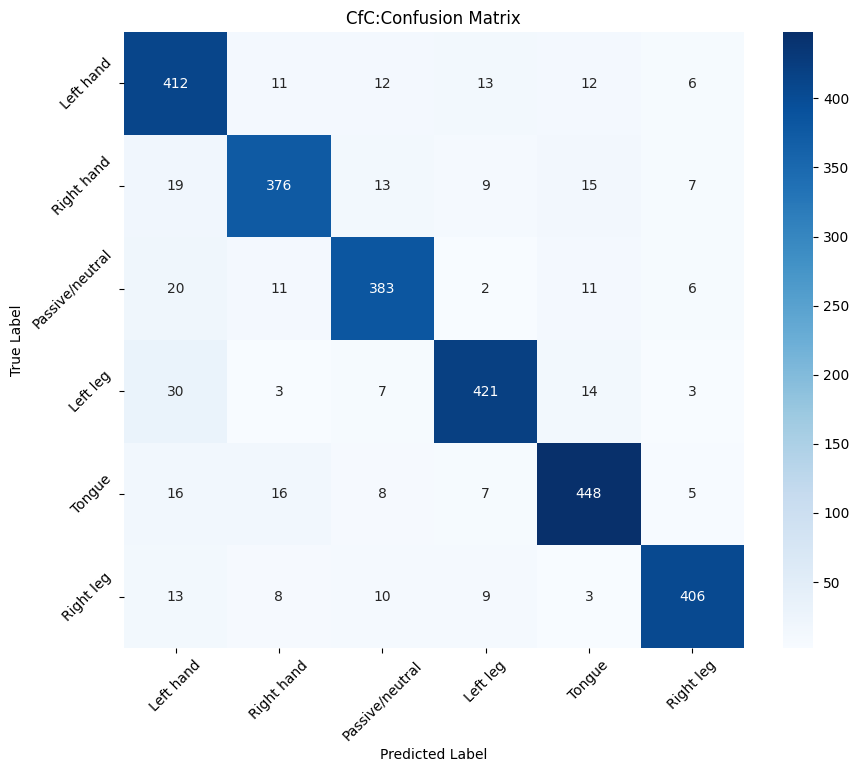

Average Prediction Time (s/sample),▁
Model Weights (MB),▁
Number of Parameters,▁
Test Accuracy,▁
Test F1-score,▁
Test Precision,▁
Test Recall,▁
accuracy,▁▃▄▄▅▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇▇▆▇▇▇▇███
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▂▂▁▁▁
val_accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▆▇▇▇▇▇███


In [ ]:
with tf.device('/device:GPU:0'):
      name = "CfC"
      model = TimeSeriesModelCfC(diodes, config['convolutions_conf'], config['dense_conf'], cfc_conf=config['cfc'])
      fit_args["experiment_name"] = f"{name}"

      # Instantiate the model
      model.build(input_shape=(batch_size, versions, time_steps, diodes))

      # Wrap the model with WandbKerasModel
      wandb_model = WandbKerasModel(
          model=model, project_name="hda-big-3", config={}, entity="bdma"
      )
      # Model summary to check the architecture
      wandb_model.model.summary()

      # Compile and fit the model
      start_time = time.time()
      wandb_model.compile_and_fit(
          compile_args={
              "optimizer": "adam",
              "loss": "sparse_categorical_crossentropy",
              "metrics": ["accuracy"],
          },
          fit_args=fit_args,
          config_path='colab_config.yaml'
      )
      end_time = time.time() - start_time
      print(f"Training time of {config['epochs']} epochs, running for: {end_time} seconds")

      # Evaluate the model on the test set and print the confusion matrix
      predict_and_plot(wandb_model, test_dataset, config, title=f"{name}")

      wandb_model.finish_experiment()

      del wandb_model
      del model

Model: "time_series_model_cf_c_with_ncp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windows_convolution_layer   multiple                  7812      
 (WindowsConvolutionLayer)                                       
                                                                 
 cf_c (CfC)                  multiple                  132096    
                                                                 
 batch_normalization (Batch  multiple                  192       
 Normalization)                                                  
                                                                 
 dense_layer (DenseLayer)    multiple                  288998    
                                                                 
Total params: 429098 (1.64 MB)
Trainable params: 429002 (1.64 MB)
Non-trainable params: 96 (384.00 Byte)
______________________________________________________________

wandb: Currently logged in as: satriabw (bdma). Use `wandb login --relogin` to force relogin


Epoch 1/30
30/30 [==============================] - 68s 990ms/step - loss: 1.5700 - accuracy: 0.3654 - val_loss: 1.7663 - val_accuracy: 0.2747
Epoch 2/30
30/30 [==============================] - 25s 742ms/step - loss: 1.2982 - accuracy: 0.4982 - val_loss: 1.7709 - val_accuracy: 0.3411
Epoch 3/30
30/30 [==============================] - 23s 736ms/step - loss: 1.1701 - accuracy: 0.5565 - val_loss: 1.7722 - val_accuracy: 0.4130
Epoch 4/30
30/30 [==============================] - 23s 738ms/step - loss: 1.0990 - accuracy: 0.5850 - val_loss: 1.7844 - val_accuracy: 0.2866
Epoch 5/30
30/30 [==============================] - 22s 701ms/step - loss: 1.0586 - accuracy: 0.5981 - val_loss: 1.7679 - val_accuracy: 0.3966
Epoch 6/30
30/30 [==============================] - 24s 748ms/step - loss: 1.0344 - accuracy: 0.6098 - val_loss: 1.7476 - val_accuracy: 0.4565
Epoch 7/30
30/30 [==============================] - 24s 743ms/step - loss: 0.9986 - accuracy: 0.6224 - val_loss: 1.6722 - val_accuracy: 0.5460

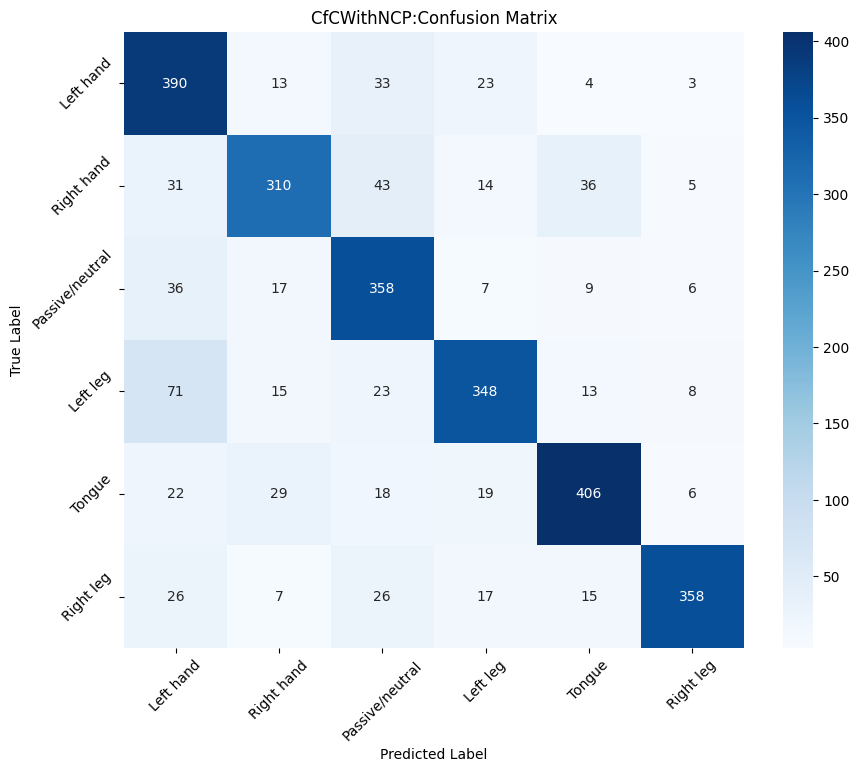

Average Prediction Time (s/sample),▁
Model Weights (MB),▁
Number of Parameters,▁
Test Accuracy,▁
Test F1-score,▁
Test Precision,▁
Test Recall,▁
accuracy,▁▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇██████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▁▃▄▅▆▅▅▆▅▆▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇██


In [ ]:
with tf.device('/device:GPU:0'):
      name = "CfCWithNCP"
      model = TimeSeriesModelCfCWithNCP(diodes, config['convolutions_conf'], config['dense_conf'], cfc_conf=config['cfc'], wiring_conf=config['wiring'])
      fit_args["experiment_name"] = f"{name}"

      # Instantiate the model
      model.build(input_shape=(batch_size, versions, time_steps, diodes))

      # Wrap the model with WandbKerasModel
      wandb_model = WandbKerasModel(
          model=model, project_name="hda-big-3", config={}, entity="bdma"
      )
      # Model summary to check the architecture
      wandb_model.model.summary()

      # Compile and fit the model
      start_time = time.time()
      wandb_model.compile_and_fit(
          compile_args={
              "optimizer": "adam",
              "loss": "sparse_categorical_crossentropy",
              "metrics": ["accuracy"],
          },
          fit_args=fit_args,
          config_path='colab_config.yaml'
      )
      end_time = time.time() - start_time
      print(f"Training time of {config['epochs']} epochs, running for: {end_time} seconds")

      # Evaluate the model on the test set and print the confusion matrix
      predict_and_plot(wandb_model, test_dataset, config, title=f"{name}")

      wandb_model.finish_experiment()

      del wandb_model
      del model

Model: "time_series_model_vanilla_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windows_convolution_layer   multiple                  7812      
 (WindowsConvolutionLayer)                                       
                                                                 
 simple_rnn (SimpleRNN)      multiple                  81024     
                                                                 
 dense_layer (DenseLayer)    multiple                  770278    
                                                                 
Total params: 859114 (3.28 MB)
Trainable params: 859114 (3.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


wandb: Currently logged in as: satriabw (bdma). Use `wandb login --relogin` to force relogin


Epoch 1/30
30/30 [==============================] - 50s 567ms/step - loss: 1.6285 - accuracy: 0.3427 - val_loss: 1.5410 - val_accuracy: 0.4018
Epoch 2/30
30/30 [==============================] - 11s 278ms/step - loss: 1.4018 - accuracy: 0.4634 - val_loss: 1.3380 - val_accuracy: 0.4841
Epoch 3/30
30/30 [==============================] - 10s 278ms/step - loss: 1.2561 - accuracy: 0.5209 - val_loss: 1.1190 - val_accuracy: 0.5892
Epoch 4/30
30/30 [==============================] - 10s 281ms/step - loss: 1.1317 - accuracy: 0.5763 - val_loss: 1.1000 - val_accuracy: 0.5868
Epoch 5/30
30/30 [==============================] - 10s 280ms/step - loss: 1.0813 - accuracy: 0.5937 - val_loss: 0.9949 - val_accuracy: 0.6300
Epoch 6/30
30/30 [==============================] - 10s 283ms/step - loss: 1.0222 - accuracy: 0.6169 - val_loss: 0.9528 - val_accuracy: 0.6456
Epoch 7/30
30/30 [==============================] - 9s 250ms/step - loss: 0.9821 - accuracy: 0.6322 - val_loss: 0.9536 - val_accuracy: 0.6397


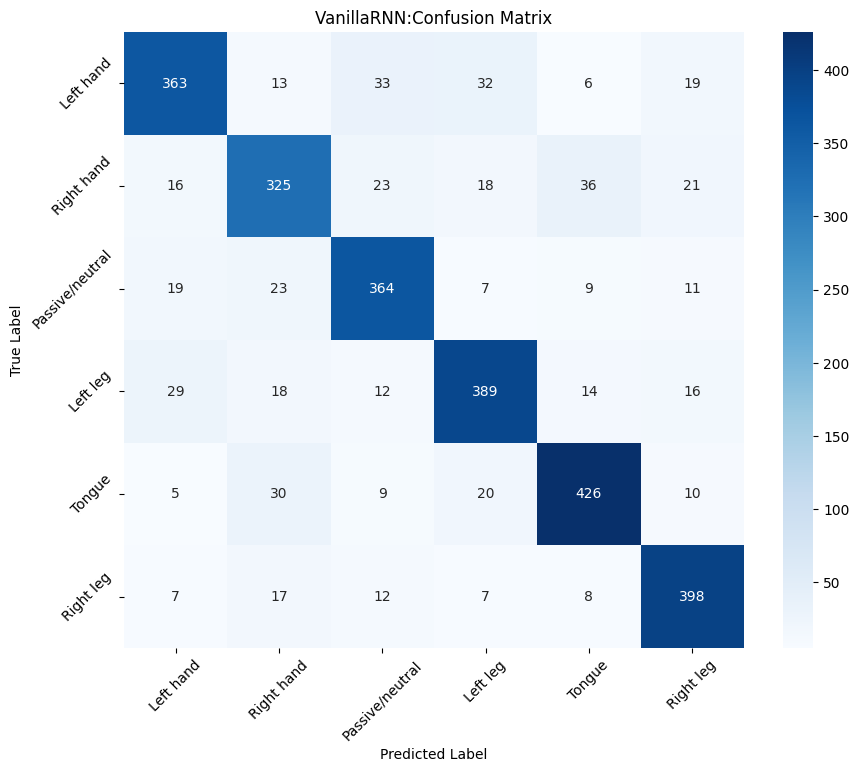

Average Prediction Time (s/sample),▁
Model Weights (MB),▁
Number of Parameters,▁
Test Accuracy,▁
Test F1-score,▁
Test Precision,▁
Test Recall,▁
accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇██


In [ ]:
with tf.device('/device:GPU:0'):
      name = "VanillaRNN"
      model = TimeSeriesModelVanillaRNN(diodes, config['convolutions_conf'], config['dense_conf'], rnn_conf=config['simple_rnn'])
      fit_args["experiment_name"] = f"{name}"

      # Instantiate the model
      model.build(input_shape=(batch_size, versions, time_steps, diodes))

      # Wrap the model with WandbKerasModel
      wandb_model = WandbKerasModel(
          model=model, project_name="hda-big-3", config={}, entity="bdma"
      )
      # Model summary to check the architecture
      wandb_model.model.summary()

      # Compile and fit the model
      start_time = time.time()
      wandb_model.compile_and_fit(
          compile_args={
              "optimizer": "adam",
              "loss": "sparse_categorical_crossentropy",
              "metrics": ["accuracy"],
          },
          fit_args=fit_args,
          config_path='colab_config.yaml'
      )
      end_time = time.time() - start_time
      print(f"Training time of {config['epochs']} epochs, running for: {end_time} seconds")

      # Evaluate the model on the test set and print the confusion matrix
      predict_and_plot(wandb_model, test_dataset, config, title=f"{name}")

      wandb_model.finish_experiment()

      del wandb_model
      del model